<a href="https://colab.research.google.com/github/bghaendler/BJBS-AI-LAB/blob/master/BJBS_AI_Lab_Session_02_CoronaVirus_Conv2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="300" src="https://raw.githubusercontent.com/bghaendler/BJBS-AI-LAB/master/img/BJBSAILogo.png" align="right"> 
# Session 2: CoronaVirus -Conv2019 Analysis

## Libraries

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
#!pip install geopy

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
from geopy.geocoders import Nominatim

In [0]:
import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [0]:
import plotly
import plotly.express as px

In [0]:
#import os
#print(os.listdir("input"))

## Exploratory Data Analysis


### Data download

Data source: https://github.com/CSSEGISandData/COVID-19

In [0]:
githubLoc = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'

In [0]:
from datetime import date, timedelta

sdate = date(2020, 1, 22)   # start date
edate = date.today()   # end date

delta = edate - sdate       # as timedelta

appended_data = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    #print(day.strftime('%m-%d-%Y'))
    try:
      df = pd.read_csv(githubLoc + day.strftime('%m-%d-%Y')+".csv", parse_dates=True)
      df["FileDate"] = day.strftime('%m-%d-%Y')
      df.rename(columns={
          "Country/Region":"Country_Region",
          "Long_":"Longitude",
          "Lat":"Latitude",
          "Province/State":"Province_State",
          "Last Update":"Last_Update"}, inplace=True)
      appended_data.append(df)
    except:
      pass
df_corona = pd.concat(appended_data)
df_corona["Last_Update"] = df_corona["Last_Update"].astype('datetime64[D]')


In [71]:
df_corona.head()

Province_State  Country_Region Last_Update  ...  Admin2  Active  Combined_Key
0          Anhui  Mainland China  2020-01-22  ...     NaN     NaN           NaN
1        Beijing  Mainland China  2020-01-22  ...     NaN     NaN           NaN
2      Chongqing  Mainland China  2020-01-22  ...     NaN     NaN           NaN
3         Fujian  Mainland China  2020-01-22  ...     NaN     NaN           NaN
4          Gansu  Mainland China  2020-01-22  ...     NaN     NaN           NaN

[5 rows x 13 columns]

In [72]:
set(df_corona.columns)

{'Active',
 'Admin2',
 'Combined_Key',
 'Confirmed',
 'Country_Region',
 'Deaths',
 'FIPS',
 'FileDate',
 'Last_Update',
 'Latitude',
 'Longitude',
 'Province_State',
 'Recovered'}

In [0]:
#df_corona["Last Update"] = df_corona["Last Update"].astype('datetime64[D]')
df_corona["Date"] = df_corona["Last_Update"]#.astype('datetime64[D]')
df_corona['Country_Region'].replace({'Mainland China':'China'},inplace=True)
df_corona.fillna(value=0, inplace=True)


### Show Cases by Date

In [74]:
df_byDate = df_corona.groupby(by=["FileDate"]).sum().reset_index().sort_values(by="FileDate").set_index("FileDate")
df_byDate["mort_Rate"] =(df_byDate["Deaths"]/df_byDate["Confirmed"])*100
df_byDate.reset_index(inplace=True)
df_byDate[["FileDate","Confirmed","Deaths","Recovered","mort_Rate"]].tail(20)

FileDate  Confirmed    Deaths  Recovered  mort_Rate
60  03-22-2020   337122.0   14623.0    97243.0   4.337599
61  03-23-2020   378287.0   16497.0   100958.0   4.360975
62  03-24-2020   417966.0   18615.0   107705.0   4.453712
63  03-25-2020   467594.0   21181.0   113770.0   4.529784
64  03-26-2020   529591.0   23970.0   122150.0   4.526134
65  03-27-2020   593291.0   27198.0   130915.0   4.584260
66  03-28-2020   660693.0   30652.0   139415.0   4.639371
67  03-29-2020   720140.0   33925.0   149082.0   4.710890
68  03-30-2020   782389.0   37582.0   164566.0   4.803493
69  03-31-2020   857487.0   42107.0   178034.0   4.910512
70  04-01-2020   932605.0   46809.0   193177.0   5.019167
71  04-02-2020  1013303.0   52983.0   210263.0   5.228742
72  04-03-2020  1095917.0   58787.0   225796.0   5.364184
73  04-04-2020  1197408.0   64606.0   246152.0   5.395488
74  04-05-2020  1272115.0   69374.0   260012.0   5.453438
75  04-06-2020  1345101.0   74565.0   276515.0   5.543450
76  04-07-2020  1426096.0   81865.0   300054.0   5.740497
77  04-08-2020  1511104.0   88338.0   328661.0   5.845925
78  04-09-2020  1595350.0   95455.0   353975.0   5.983327
79  04-10-2020  1691719.0  102525.0   376096.0   6.060404

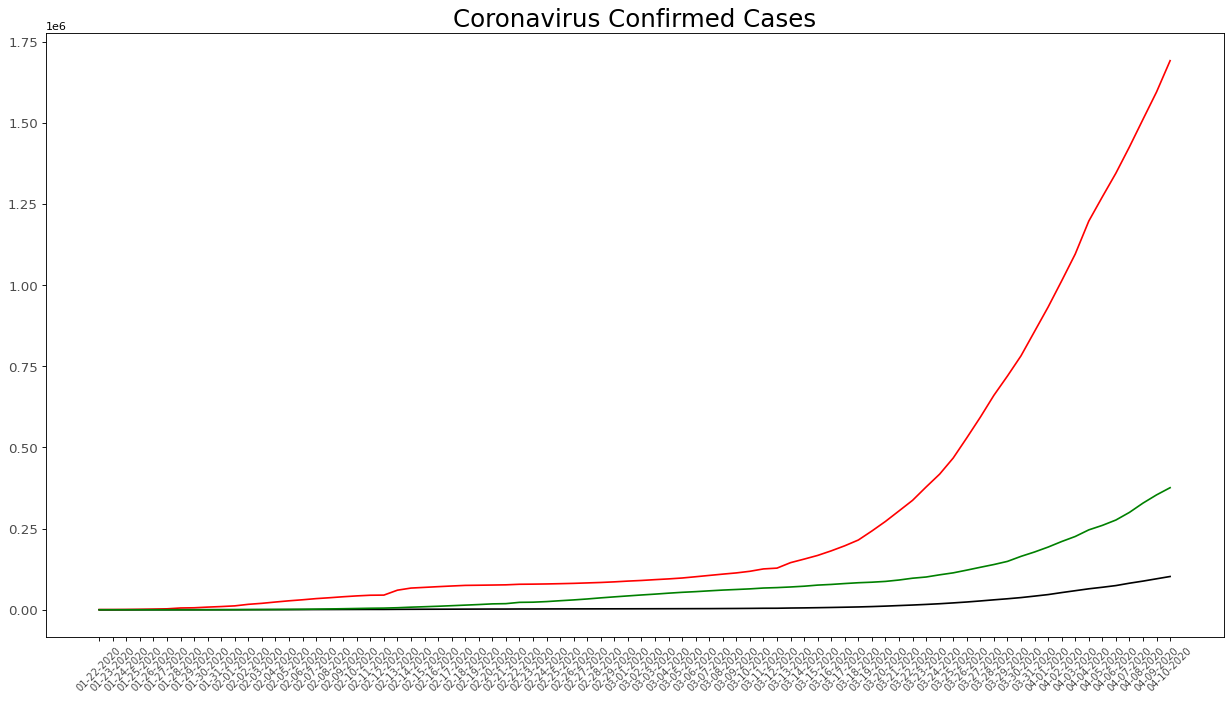

In [75]:
# Draw Plot
plt.figure(figsize=(19,10), dpi= 80)
plt.plot('FileDate', 'Confirmed', data=df_byDate, color='red')
plt.plot('FileDate', 'Deaths', data=df_byDate, color='black')
plt.plot('FileDate', 'Recovered', data=df_byDate, color='green')
# Decoration
#plt.ylim(50, 750)
#xtick_location = df_byDate.index.tolist()[::12]
#xtick_labels = [df_byDate.FileDate.tolist()]
plt.xticks(rotation=45, fontsize=9, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Coronavirus Confirmed Cases", fontsize=22)
#plt.grid(axis='both', alpha=.3)

# Remove borders
#plt.gca().spines["top"].set_alpha(0.0)    
#plt.gca().spines["bottom"].set_alpha(0.3)
#plt.gca().spines["right"].set_alpha(0.0)    
#plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

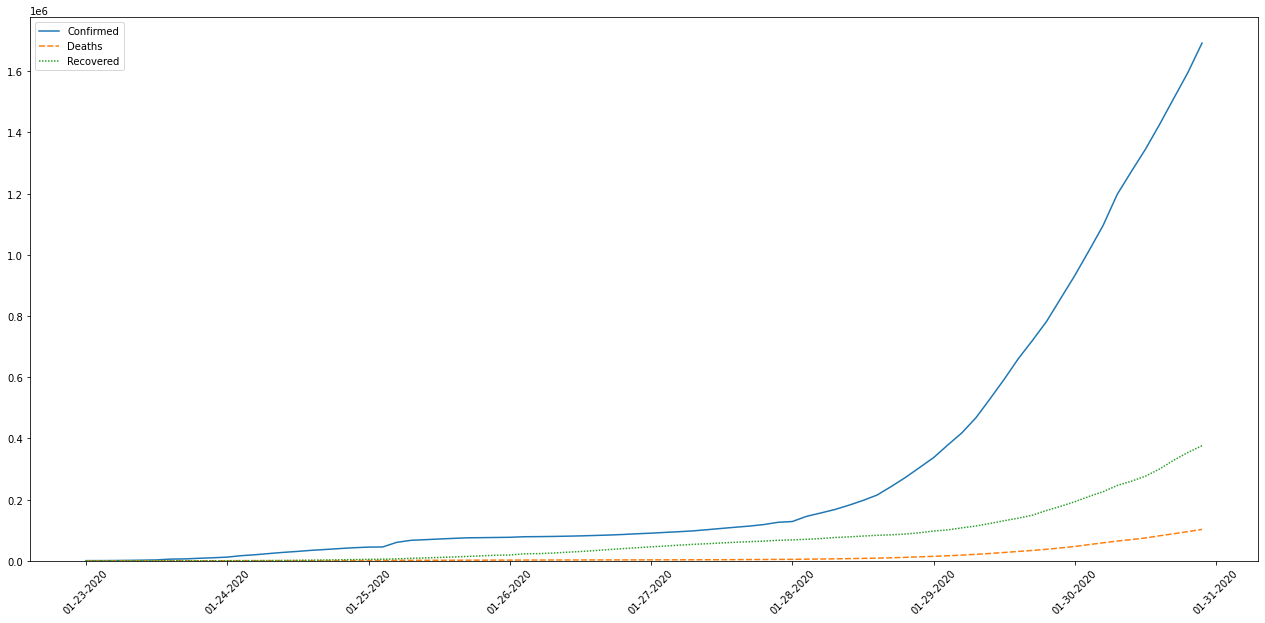

In [76]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot(data=df_byDate[["Confirmed","Deaths","Recovered"]])  
fig.set_xticklabels(df_byDate['FileDate'])
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

### Number of Cases in China

In [0]:
#df_corona.groupby(by="Date").sum().reset_index().sort_values(by="Date").diff()

In [78]:
nb_cases_day = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China = df_corona.loc[df_corona["Country_Region"] == "China"].groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China.tail()

Confirmed  Deaths  Recovered  Latitude  Longitude  FIPS  Active
Date                                                                       
2020-04-06     3662.0   120.0     3714.0   41.8951   -78.5809   0.0  -172.0
2020-04-07    -5195.0  -100.0    -5115.0 -141.4547  -353.5843   0.0    20.0
2020-04-08    -2021.0   -22.0    -1994.0  -15.5465   -21.9676   0.0    -5.0
2020-04-09     4009.0    34.0     4131.0   81.3907    99.6146   0.0  -156.0
2020-04-10    -4647.0   -41.0    -4488.0 -271.0650  -808.4669   0.0  -118.0

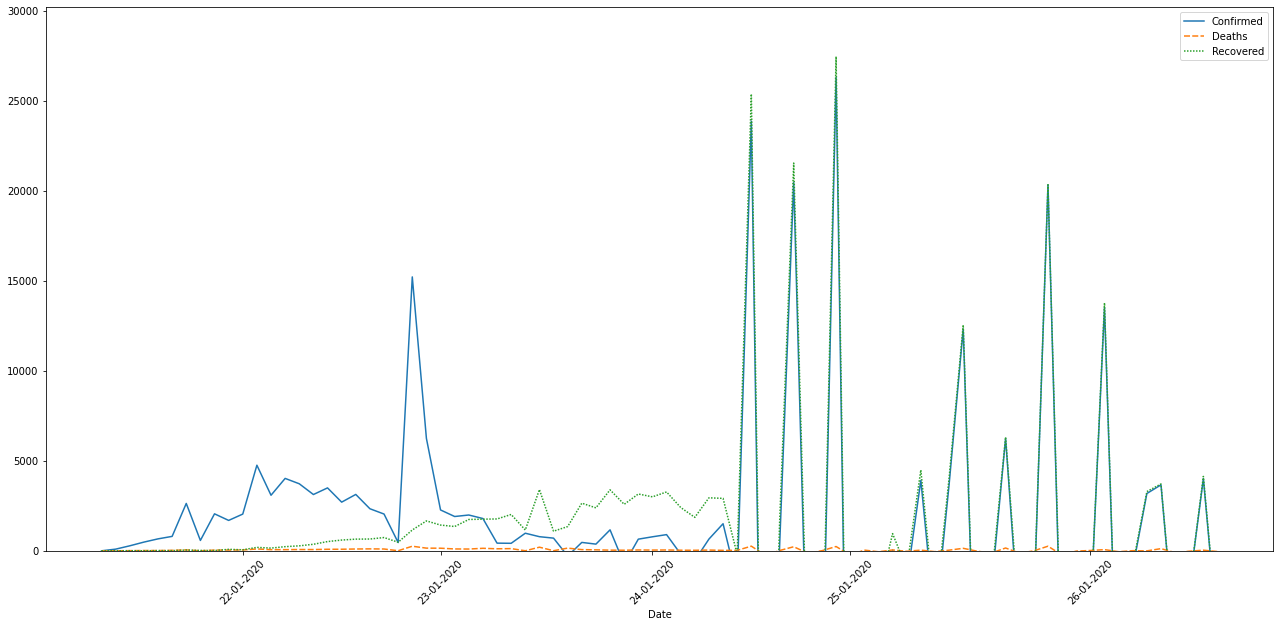

In [79]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot( 
    data=nb_cases_day_China[["Confirmed","Deaths","Recovered"]])  
fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

In [0]:
nb_cases_day = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_Spain = df_corona.loc[df_corona["Country_Region"] == "Spain"]
#nb_cases_day_Spain

In [81]:
fig, ax = plt.subplots(figsize = (22,10))    
fig = sns.barplot(
    x = "Date", 
    y = "Confirmed", 
    data = nb_cases_day.rolling(window=12).mean().dropna().reset_index())

fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

In [82]:
df_corona["Date"].max()

Timestamp('2020-04-10 00:00:00')

In [83]:
df_corona.describe()

Confirmed        Deaths  ...          FIPS        Active
count   68397.000000  68397.000000  ...  68397.000000  68397.000000
mean      346.300949     17.095297  ...  24733.370660    137.207685
std      4111.972643    335.869411  ...  18885.378529   2393.971856
min         0.000000      0.000000  ...      0.000000     -6.000000
25%         1.000000      0.000000  ...   6055.000000      0.000000
50%         4.000000      0.000000  ...  23017.000000      0.000000
75%        25.000000      0.000000  ...  40109.000000      0.000000
max    158273.000000  18849.000000  ...  99999.000000  98273.000000

[8 rows x 7 columns]

### Dataframe Info

In [84]:
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68397 entries, 0 to 2941
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province_State  68397 non-null  object        
 1   Country_Region  68397 non-null  object        
 2   Last_Update     68397 non-null  datetime64[ns]
 3   Confirmed       68397 non-null  float64       
 4   Deaths          68397 non-null  float64       
 5   Recovered       68397 non-null  float64       
 6   FileDate        68397 non-null  object        
 7   Latitude        68397 non-null  float64       
 8   Longitude       68397 non-null  float64       
 9   FIPS            68397 non-null  float64       
 10  Admin2          68397 non-null  object        
 11  Active          68397 non-null  float64       
 12  Combined_Key    68397 non-null  object        
 13  Date            68397 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(7), object(5)
memory usag

In [85]:
#**Present Gobal condition: confirmed, death and recovered**
print('Data from Day: ' + str(df_corona["Date"].max().strftime('%A %m/%d/%Y')))
print('Globally Confirmed Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Confirmed'].sum())
print('Global Deaths: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Deaths'].sum())
print('Globally Recovered Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Recovered'].sum())

Data from Day: Friday 04/10/2020
Globally Confirmed Cases:  1683971.0
Global Deaths:  102451.0
Globally Recovered Cases:  368551.0


In [86]:
df_corona[['Date','Country_Region','Province_State','Confirmed','Deaths','Recovered']].drop_duplicates(subset=["Date","Province_State"]).groupby(['Date','Country_Region']).sum()

Confirmed  Deaths  Recovered
Date       Country_Region                              
2020-01-22 China               547.0    17.0       28.0
           Hong Kong             0.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
...                              ...     ...        ...
2020-04-10 Denmark             195.0     0.0      156.0
           France             1062.0    18.0      263.0
           Netherlands         152.0     9.0       37.0
           US                12278.0   385.0        0.0
           United Kingdom      847.0    16.0      244.0

[587 rows x 3 columns]

In [87]:
df_corona.loc[df_corona["Date"]==df_corona["Date"].max()].groupby('Country_Region')['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Confirmed   Deaths  Recovered
Country_Region                                 
US                 496535.0  18586.0    28790.0
Spain              158273.0  16081.0    55668.0
Italy              147577.0  18849.0    30455.0
France             125931.0  13215.0    25195.0
Germany            122171.0   2767.0    53913.0
...                     ...      ...        ...
Western Sahara          4.0      0.0        0.0
Burundi                 3.0      0.0        0.0
Timor-Leste             2.0      0.0        1.0
Papua New Guinea        2.0      0.0        0.0
Yemen                   1.0      0.0        0.0

[185 rows x 3 columns]

In [89]:
df_corona.loc[df_corona["Country_Region"] == "China"].groupby("Date").sum()

Confirmed  Deaths  Recovered  Latitude  Longitude  FIPS  Active
Date                                                                       
2020-01-22      547.0    17.0       28.0    0.0000     0.0000   0.0     0.0
2020-01-23      639.0    18.0       30.0    0.0000     0.0000   0.0     0.0
2020-01-24      916.0    26.0       36.0    0.0000     0.0000   0.0     0.0
2020-01-25     1399.0    42.0       39.0    0.0000     0.0000   0.0     0.0
2020-01-26     2062.0    56.0       49.0    0.0000     0.0000   0.0     0.0
...               ...     ...        ...       ...        ...   ...     ...
2020-04-06    83047.0  3395.0    77712.0  824.4630  2715.5512   0.0  1940.0
2020-04-07    77852.0  3295.0    72597.0  683.0083  2361.9669   0.0  1960.0
2020-04-08    75831.0  3273.0    70603.0  667.4618  2339.9993   0.0  1955.0
2020-04-09    79840.0  3307.0    74734.0  748.8525  2439.6139   0.0  1799.0
2020-04-10    75193.0  3266.0    70246.0  477.7875  1631.1470   0.0  1681.0

[80 rows x 7 columns]

In [91]:
CasesByCountry = df_corona.groupby(by=['Country_Region','Date'])['Confirmed','Deaths','Recovered'].sum().reset_index()
CasesByCountry.loc[CasesByCountry["Date"] == CasesByCountry["Date"].max()]
CasesByCountry.loc[CasesByCountry["Date"] == '2020-02-23'].sort_values("Confirmed", ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Country_Region       Date  Confirmed  Deaths  Recovered
1113          China 2020-02-23    77445.0  2445.0    23633.0
4046         Others 2020-02-23     2073.0     9.0        0.0
4928    South Korea 2020-02-23      602.0     6.0       18.0
4739      Singapore 2020-02-23      178.0     0.0      102.0
2700          Italy 2020-02-23      155.0     3.0        2.0
2802          Japan 2020-02-23      147.0     1.0       22.0
2353      Hong Kong 2020-02-23       74.0     2.0       11.0
5292       Thailand 2020-02-23       70.0     0.0       42.0
2527           Iran 2020-02-23       43.0     8.0        0.0
5208         Taiwan 2020-02-23       28.0     1.0        2.0
2574           Iraq 2020-02-23        0.0     0.0        0.0

In [93]:
pivotTableCorna = pd.pivot_table(df_corona,index="Country_Region", columns="Date", values="Confirmed" ,fill_value=0,aggfunc='sum').reset_index()
pivotTableCorna

Date                  Country_Region  ...  2020-04-10 00:00:00
0                         Azerbaijan  ...                    0
1                        Afghanistan  ...                  521
2                            Albania  ...                  416
3                            Algeria  ...                 1761
4                            Andorra  ...                  601
..                               ...  ...                  ...
229                   Western Sahara  ...                    4
230                            Yemen  ...                    1
231                           Zambia  ...                   40
232                         Zimbabwe  ...                   13
233   occupied Palestinian territory  ...                    0

[234 rows x 81 columns]

In [0]:
#f, ax = plt.subplots(figsize=(17, 15))
#ax = sns.heatmap(pivotTableCorna)

In [94]:
CasesByCountry.tail()

Country_Region       Date  Confirmed  Deaths  Recovered
5874                        Zimbabwe 2020-04-08       11.0     3.0        0.0
5875                        Zimbabwe 2020-04-09       11.0     3.0        0.0
5876                        Zimbabwe 2020-04-10       13.0     3.0        0.0
5877  occupied Palestinian territory 2020-03-10       25.0     0.0        0.0
5878  occupied Palestinian territory 2020-03-11        0.0     0.0        0.0

In [95]:
CasesByCountry["Date"].max()

Timestamp('2020-04-10 00:00:00')

In [96]:
df_corona.loc[
              df_corona["Date"]==df_corona["Date"].max()].groupby(
                  ['Province_State'])['Confirmed','Deaths','Recovered'].sum().sort_values(
                      by="Confirmed", ascending=False).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Confirmed   Deaths  Recovered
Province_State                               
0               1081713.0  79945.0   261167.0
New York         172348.0   7867.0        0.0
Hubei             67803.0   3216.0    64236.0
New Jersey        54588.0   1932.0        0.0
Michigan          22434.0   1276.0        0.0
California        21081.0    583.0        0.0
Massachusetts     20974.0    599.0        0.0
Pennsylvania      20051.0    418.0        0.0
Louisiana         19253.0    755.0        0.0
Illinois          17887.0    597.0        0.0

In [98]:
df_corona2 = df_corona.groupby(['Date','Country_Region'])['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [0]:
df_corona2.reset_index(inplace=True)

In [100]:
fig = px.bar(
    df_corona2[['Date','Confirmed','Deaths', 'Recovered','Country_Region']], 
    x='Date', 
    y='Confirmed', 
    hover_data=['Country_Region', 'Deaths', 'Recovered'], 
    color='Country_Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [0]:
df_corona3 =df_corona2.loc[df_corona2["Country_Region"] !="China"]

In [103]:
fig = px.bar(
    df_corona3[['Date','Confirmed','Deaths', 'Recovered','Country_Region']], 
    x='Date', 
    y='Deaths', 
    hover_data=['Country_Region', 'Deaths', 'Recovered'], 
    color='Country_Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [104]:
fig = px.bar(df_corona.loc[df_corona['Country_Region'] == 'China'], x='Date', y='Confirmed', hover_data=['Province_State', 'Deaths', 'Recovered'], color='Province_State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [105]:
fig = px.bar(df_corona.loc[df_corona['Country_Region'] == 'Singapore'].drop_duplicates(subset="Date"), 
             x='Date', y='Confirmed', 
             hover_data=['Deaths', 'Recovered'])
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Singapore',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [106]:
fig = px.bar(df_corona, x='Date', y='Deaths', hover_data=['Province_State', 'Confirmed', 'Recovered'], color='Country_Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for each country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [108]:
fig = px.bar(df_corona.loc[df_corona['Country_Region'] == 'China'], x='Date', y='Deaths', hover_data=['Province_State', 'Confirmed', 'Recovered'], color='Province_State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

## Predicting Using Facebook Prophet vs Sklearn

In [0]:
from fbprophet.plot import plot_plotly
from fbprophet import Prophet

In [0]:
confirmed_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#confirmed_training_dataset

In [111]:
# Making the Model
prophet = Prophet()
prophet.fit(confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=37)
confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [112]:
fig = plot_plotly(prophet, confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
death_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Deaths'].sum().reset_index()).rename(columns={'Date': 'ds', 'Deaths': 'y'})
#death_training_dataset

In [114]:
# Making the Model
prophet = Prophet()
prophet.fit(death_training_dataset)
future = prophet.make_future_dataframe(periods=30)
deaths_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [115]:
fig = plot_plotly(prophet, deaths_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions of Deaths',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
sg_confirmed_training_dataset = pd.DataFrame(df_corona.loc[df_corona['Country_Region'] == 'Singapore'].drop_duplicates(subset="Date").groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#sg_confirmed_training_dataset

In [117]:
# Making the Model
prophet = Prophet()
prophet.fit(sg_confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=30)
sg_confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
fig = plot_plotly(prophet, sg_confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

### Number of cases per day

### Prediction Singapore Cases Per Day

In [0]:
df_corona_cases_day_sg =df_corona.loc[df_corona["Country_Region"] == "Singapore"].drop_duplicates(subset="Date").groupby(by=["Country_Region","Date"]).sum().diff()
#df_corona.loc[df_corona["Country/Region"] == "Singapore"].groupby(by=["Country/Region","Date"]).sum()

In [0]:
SG_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_sg.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#SG_CasesPerDay_training_dataset

In [128]:
# Making the Model
prophet = Prophet()
prophet.fit(SG_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
SG_CasesPerDay_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [129]:
fig = plot_plotly(prophet, SG_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Singapore Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

22.187575044995548
0.792258828425576


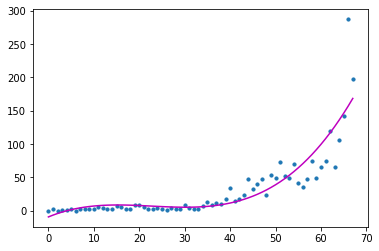

In [130]:
x = np.arange(0, SG_CasesPerDay_training_dataset.shape[0], dtype=int)
y = SG_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### China Prediction Cases Per Day

In [0]:
df_corona_cases_day_cn = df_corona.loc[df_corona["Country_Region"] == "China"].drop_duplicates(subset="Date").groupby(by=["Country_Region","Date"]).sum().diff()

In [0]:
CN_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_cn.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#CN_CasesPerDay_training_dataset

In [133]:
# Making the Model
prophet = Prophet()
prophet.fit(CN_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
CN_CasesPerDay_forecast = prophet.predict(future)
#CN_CasesPerDay_forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [134]:
fig = plot_plotly(prophet, CN_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='China Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

7726.07117184483
0.035787730864548783


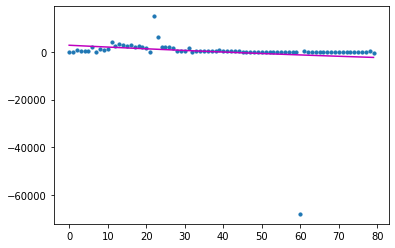

In [135]:
x = np.arange(0, CN_CasesPerDay_training_dataset.shape[0], dtype=int)
y = CN_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Prediction Spain Confirmed

In [0]:

df_corona_cases_day_spain =df_corona.loc[df_corona["Country_Region"] == "Spain"].drop_duplicates(subset="Date").groupby(by=["Country_Region","Date"]).sum().diff()
#df_corona.loc[df_corona["Country/Region"] == "Singapore"].groupby(by=["Country/Region","Date"]).sum()

In [0]:
df_corona_cases_day_spain

In [0]:
Spain_CasesPerDay_training_dataset = pd.DataFrame(df_corona.loc[
                                                                (df_corona["Country_Region"] == "Spain")&(df_corona["Date"] > "20200215")].drop_duplicates(subset="Date").groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})

In [140]:
# Making the Model
prophet = Prophet()
prophet.fit(Spain_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=120)
Spain_CasesPerDay_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [141]:
fig = plot_plotly(prophet, Spain_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Spain Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

4957.158822622556
0.9914592904461926


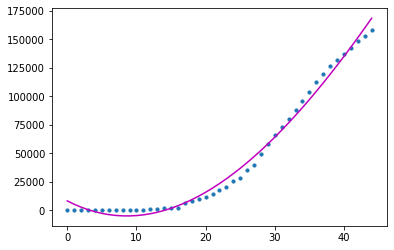

In [142]:
x = np.arange(0, Spain_CasesPerDay_training_dataset.shape[0], dtype=int)
y = Spain_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Calculate Mortality Rate
By Country/Date

In [143]:
df_corona.groupby("Date").sum()

Confirmed    Deaths  Recovered  ...      Longitude        FIPS    Active
Date                                        ...                                     
2020-01-22      555.0      17.0       28.0  ...       0.000000         0.0       0.0
2020-01-23      653.0      18.0       30.0  ...       0.000000         0.0       0.0
2020-01-24      941.0      26.0       36.0  ...       0.000000         0.0       0.0
2020-01-25     1438.0      42.0       39.0  ...       0.000000         0.0       0.0
2020-01-26     2118.0      56.0       52.0  ...       0.000000         0.0       0.0
...               ...       ...        ...  ...            ...         ...       ...
2020-04-06  1345483.0   74625.0   276917.0  ... -220915.423892  78475165.0  644670.0
2020-04-07  1421230.0   81825.0   295241.0  ... -225479.407562  80247682.0  668720.0
2020-04-08  1504126.0   88274.0   321697.0  ... -227838.934967  81147344.0  688777.0
2020-04-09  1592307.0   95423.0   351030.0  ... -230235.097947  82139914.0  711316.0
2020-04-10  1683971.0  102451.0   368551.0  ... -233779.429800  83119953.0  748163.0

[80 rows x 7 columns]

In [144]:
df_corona_MortRate = df_corona.groupby(by=["Date"]).sum().reset_index()
df_corona_MortRate

Date  Confirmed    Deaths  ...      Longitude        FIPS    Active
0  2020-01-22      555.0      17.0  ...       0.000000         0.0       0.0
1  2020-01-23      653.0      18.0  ...       0.000000         0.0       0.0
2  2020-01-24      941.0      26.0  ...       0.000000         0.0       0.0
3  2020-01-25     1438.0      42.0  ...       0.000000         0.0       0.0
4  2020-01-26     2118.0      56.0  ...       0.000000         0.0       0.0
..        ...        ...       ...  ...            ...         ...       ...
75 2020-04-06  1345483.0   74625.0  ... -220915.423892  78475165.0  644670.0
76 2020-04-07  1421230.0   81825.0  ... -225479.407562  80247682.0  668720.0
77 2020-04-08  1504126.0   88274.0  ... -227838.934967  81147344.0  688777.0
78 2020-04-09  1592307.0   95423.0  ... -230235.097947  82139914.0  711316.0
79 2020-04-10  1683971.0  102451.0  ... -233779.429800  83119953.0  748163.0

[80 rows x 8 columns]

In [0]:
df_corona_MortRate["MortalityRate"] = df_corona_MortRate["Deaths"]/df_corona_MortRate["Confirmed"]
df_corona_MortRate["MortalityRate"].replace([np.inf, -np.inf], np.nan)
df_corona_MortRate["MortalityRate"].fillna(value=0, inplace=True)


In [0]:
#df_corona_MortRate["MortalityRate"].loc[(~np.isfinite(df_corona_MortRate["MortalityRate"])) & df_corona_MortRate["MortalityRate"].notnull()] = 0

In [146]:
df_corona_MortRate.sort_values(by="Date", ascending=False)

Date  Confirmed    Deaths  ...        FIPS    Active  MortalityRate
79 2020-04-10  1683971.0  102451.0  ...  83119953.0  748163.0       0.060839
78 2020-04-09  1592307.0   95423.0  ...  82139914.0  711316.0       0.059928
77 2020-04-08  1504126.0   88274.0  ...  81147344.0  688777.0       0.058688
76 2020-04-07  1421230.0   81825.0  ...  80247682.0  668720.0       0.057573
75 2020-04-06  1345483.0   74625.0  ...  78475165.0  644670.0       0.055463
..        ...        ...       ...  ...         ...       ...            ...
4  2020-01-26     2118.0      56.0  ...         0.0       0.0       0.026440
3  2020-01-25     1438.0      42.0  ...         0.0       0.0       0.029207
2  2020-01-24      941.0      26.0  ...         0.0       0.0       0.027630
1  2020-01-23      653.0      18.0  ...         0.0       0.0       0.027565
0  2020-01-22      555.0      17.0  ...         0.0       0.0       0.030631

[80 rows x 9 columns]

### Geolocation 1

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "bghai19" # username from the json file
os.environ['KAGGLE_KEY'] = "4947c3935b9ad98eacd876741ff7c11c" # key from the json file

In [148]:
!kaggle datasets download -d parulpandey/world-coordinates

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 1.97MB/s]


In [0]:
import zipfile

In [0]:
with zipfile.ZipFile("/content/world-coordinates.zip","r") as zip_ref:
    zip_ref.extractall("input")

In [151]:
# Importing the world_coordinates dataset
world_coordinates = pd.read_csv('/content/input/world_coordinates.csv')
world_coordinates.tail()


Code       Country   latitude  longitude
239   YE         Yemen  15.552727  48.516388
240   YT       Mayotte -12.827500  45.166244
241   ZA  South Africa -30.559482  22.937506
242   ZM        Zambia -13.133897  27.849332
243   ZW      Zimbabwe -19.015438  29.154857

In [153]:
# Merging the coordinates dataframe with original dataframe
df_corona_world = pd.merge(world_coordinates,df_corona,left_on='Country',right_on='Country_Region')
df_corona_world = df_corona_world.loc[df_corona_world["Date"] == df_corona_world["Date"].max()]
df_corona_world= df_corona_world.groupby(by=["Date","Country_Region","latitude","longitude"]).sum().reset_index()
df_corona_world

Date  Country_Region   latitude  ...   Longitude  FIPS  Active
0   2020-04-10     Afghanistan  33.939110  ...   67.709953   0.0   474.0
1   2020-04-10         Albania  41.153332  ...   20.168300   0.0   211.0
2   2020-04-10         Algeria  28.033886  ...    1.659600   0.0  1100.0
3   2020-04-10         Andorra  42.546245  ...    1.521800   0.0   504.0
4   2020-04-10          Angola -11.202692  ...   17.873900   0.0    15.0
..         ...             ...        ...  ...         ...   ...     ...
163 2020-04-10         Vietnam  14.058324  ...  108.277199   0.0   113.0
164 2020-04-10  Western Sahara  24.215527  ...  -12.885800   0.0     4.0
165 2020-04-10           Yemen  15.552727  ...   48.516388   0.0     1.0
166 2020-04-10          Zambia -13.133897  ...   27.849332   0.0    13.0
167 2020-04-10        Zimbabwe -19.015438  ...   29.154857   0.0    10.0

[168 rows x 11 columns]

In [0]:
#df_corona_world.info()

In [0]:
import plotly.express as px
import plotly.graph_objects as go

In [155]:
fig = go.Figure(data=go.Scattergeo(
        #locationmode = 'iso_alpha',
        lon = df_corona_world['longitude'],
        lat = df_corona_world['latitude'],
        text = df_corona_world['Country_Region'] + " " + df_corona_world['Confirmed'].astype(str) + ' Confirmed Cases',
        mode = 'markers',
        marker = dict(
            size = 12,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = df_corona_world['Confirmed'],
            cmax = df_corona_world['Confirmed'].max(),
            colorbar_title="Cases by" + str(df_corona_world['Date'].max())
        )))

fig.update_layout(
        title = 'Corona Virus by Country)',
        geo = dict(
            scope='world',
            #projection_type='natural earth',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [156]:

scl = [0,"#000000"],[0.5,"rgb(255, 0, 0)"],[1,"rgb(150, 204, 0)"]

fig = go.Figure(data=go.Scattergeo(
    lon = df_corona_world['longitude'],
    lat = df_corona_world['latitude'], 
    text = df_corona_world['Country_Region'] + " " +df_corona_world['Confirmed'].astype(str),
    marker = dict(
        color = df_corona_world['Confirmed'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = (df_corona_world['Confirmed']/2000)+10
    )
))

fig.update_layout(
    geo = dict(
        scope = 'world',
        showland = True,
        landcolor = "rgb(242, 242, 242)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,


    ),
    title='CoronaViruse cases ' + df_corona_world['Date'].max().strftime('%A %m/%d/%Y'),
)
fig.show()

### Geolocation2

In [0]:
import folium 
from folium import plugins

In [159]:
# create map and display it
world_map = folium.Map(location=[10, -20], zoom_start=2.3)

for lat, lon, value, name, deaths in zip(df_corona_world['latitude'], df_corona_world['longitude'], df_corona_world['Confirmed'], df_corona_world['Country_Region'], df_corona_world['Deaths']):
    folium.CircleMarker([lat, lon],
                        radius=1+(deaths/100),
                        popup = ('<strong>Country</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)
world_map